# Use Elastic-BLAST to identify RdRp genes in a viral metagenome.

In this notebook, we search WGS sequences from the Culex mosquito virome (JAIJZY01) against a BLAST database based on the supplementary materials of:

Wolf YI, Kazlauskas D, Iranzo J, Lucía-Sanz A, Kuhn JH, Krupovic M, Dolja VV, Koonin EV.
Origins and Evolution of the Global RNA Virome.
mBio. 2018 Nov 27;9(6):e02329-18. doi: 10.1128/mBio.02329-18. PMID: 30482837; PMCID: PMC6282212.


### Requirements
Please, see the [requirements.txt](https://github.com/boratyng/elastic-blast-notebook/blob/main/requirements.txt) file for required python packages.

In [1]:
import os
from uuid import uuid4
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Set up AWS credentials
You need to provide credentials for your AWS user account so that Elastic-BLAST can use cloud resources. Generating and providing user credentials is described here: https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-quickstart.html. There are two steps to this process:
1. Create AWS access keys via AWS console: https://console.aws.amazon.com/iam/
1. Paste AWS access key and AWS secret access key in the code below (remember to use quotes as these are python strings)

Note that these keys authenticate your AWS account and anyone who has them has access to your account. We recommend creating new keys for working with this notebook and inactivating them when you are done.

In [ ]:
os.environ['AWS_ACCESS_KEY_ID'] =
os.environ['AWS_SECRET_ACCESS_KEY'] =
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

## Create results bucket (if one does not exist)
Elastic-BLAST saves results in a cloud bucket. If you already have a cloud bucket in AWS, you can just provide its name.

### Name the results bucket
Select a name for your results bucket or provide your bucket name. Please, remember that bucket names must be  globally unique. You can either edit _YOURNAME_ variable or change value of _RESULTS_BUCKET_ variable.

In [98]:
YOURNAME = str(uuid4())[:8]
RESULTS_BUCKET = f'elasticblast-{YOURNAME}'
print(f'Your results bucket: s3://{RESULTS_BUCKET}')

Your results bucket: s3://elasticblast-7d373dbc


### Create results bucket
Skip if the bucket already exists.

In [ ]:
!aws s3 mb s3://{RESULTS_BUCKET}

## Optional: Enable Elastic-BLAST Auto-shutdown feature
This feature enables ElasticBLAST to monitor its status and shutdown cloud resources in the event of failures or successful search completion. It needs to be done only once per AWS user. If this feature is not enables you will need to run `elastic-blast delete` to delete cloud resources. Please, see https://blast.ncbi.nlm.nih.gov/doc/elastic-blast/janitor.html for more information. 

In [ ]:
!sed -i~ -e '/export PATH/d' $(which aws-create-elastic-blast-janitor-role.sh)
!aws-create-elastic-blast-janitor-role.sh

## Elastic-BLAST configuration file
For easier code management we will assign the Elastic-BLAST configuration file name to the variable `conf_file`.

In [3]:
conf_file = 'JAIJZY.ini'

Below is the contents of Elastic-BLAST configuration file, and running the cell below will write it to file `JAIJZY.ini`.

This configuration file instructs Elastic-BLAST to run a BLASTX search of query sequences stored in `s3://elasticblast-test/queries/JAIJZY01.1.fsa_nt.gz` against the database `s3://elasticblast-test/db/wolf18/RNAvirome.S2.RDRP`.  RNAvirome.S2.RDRP was derived from supplementary materials attached to Wolf et al.

In [5]:
%%writefile {conf_file}

[cloud-provider]
aws-region = us-east-1

[cluster]
num-nodes = 1

[blast]
program = blastx
db = s3://elasticblast-test/db/wolf18/RNAvirome.S2.RDRP
queries = s3://elasticblast-test/queries/JAIJZY01.1.fsa_nt.gz
options = -task blastx-fast -evalue 0.01 -outfmt "7 std qcovs sskingdoms ssciname"

Writing JAIJZY.ini


## Submit Elastic-BLAST search
Run the cell below to submit an Elastic-BLAST search. It will take a few minutes.

In [9]:
!elastic-blast submit --cfg {conf_file} --results s3://{RESULTS_BUCKET}

awslimitchecker 12.0.0 is AGPL-licensed free software; all users have a right to the full source code of this version. See <https://github.com/jantman/awslimitchecker>


## Check search status
The cell below checks search status. Elastic-BLAST splits query sequences into batches. _elastic-blast status_ command shows how many of these batches are pending, running, completed, or completed. When the whole search is done you will see only the message: "Your Elastic-BLAST search succeeded ..." or "Your Elastic-BLAST search failed ..."

In [ ]:
!elastic-blast status --results s3://{RESULTS_BUCKET}

## Wait until the search is done
Run the cell below to wait until the search is done. The cell will keep working until Elastic-BLAST search is complete.

In [ ]:
!elastic-blast status --results s3://{RESULTS_BUCKET} --wait

## Download results
Elastic-BLAST search is done and results are placed in your results bucket. Now we need to download the results to analyze then.

In [84]:
!aws s3 cp s3://{RESULTS_BUCKET}/ . --exclude "*" --include "*.out.gz" --recursive

download: s3://elasticblast-boratyng/eb-1456_2/batch_001-blastx-RNAvirome.S2.RDRP.out.gz to ./batch_001-blastx-RNAvirome.S2.RDRP.out.gz
download: s3://elasticblast-boratyng/eb-1456_2/batch_003-blastx-RNAvirome.S2.RDRP.out.gz to ./batch_003-blastx-RNAvirome.S2.RDRP.out.gz
download: s3://elasticblast-boratyng/eb-1456_2/batch_007-blastx-RNAvirome.S2.RDRP.out.gz to ./batch_007-blastx-RNAvirome.S2.RDRP.out.gz
download: s3://elasticblast-boratyng/eb-1456_2/batch_000-blastx-RNAvirome.S2.RDRP.out.gz to ./batch_000-blastx-RNAvirome.S2.RDRP.out.gz
download: s3://elasticblast-boratyng/eb-1456_2/batch_004-blastx-RNAvirome.S2.RDRP.out.gz to ./batch_004-blastx-RNAvirome.S2.RDRP.out.gz
download: s3://elasticblast-boratyng/eb-1456_2/batch_005-blastx-RNAvirome.S2.RDRP.out.gz to ./batch_005-blastx-RNAvirome.S2.RDRP.out.gz
download: s3://elasticblast-boratyng/eb-1456_2/batch_006-blastx-RNAvirome.S2.RDRP.out.gz to ./batch_006-blastx-RNAvirome.S2.RDRP.out.gz
download: s3://elasticblast-boratyng/eb-1456_2/b

## Uncompress and merge results
Elastic-BLAST produces compressed result files for each batch of queries. We are going to uncompress them, merge them into one file: `results.tab`, and show its first few lines.

In [85]:
%%bash
gzip -d -f batch_*.gz
cat batch_*.out | grep -v ^# >results.tab
head results.tab

JAIJZY010000003.1	RDRP_YP_009337412.1	85.294	136	20	0	15	422	328	463	6.90e-80	250	35	Viruses	Hubei virga-like virus 2
JAIJZY010000003.1	RDRP_YP_009337423.1	63.704	135	49	0	18	422	330	464	4.30e-55	186	35	Viruses	Hubei virga-like virus 1
JAIJZY010000003.1	RDRP_YP_009337659.1	38.686	137	83	1	15	425	323	458	1.98e-22	96.3	35	Viruses	Hubei virga-like virus 21
JAIJZY010000003.1	RDRP_AMO03256.1	40.602	133	76	2	30	422	331	462	2.57e-22	95.9	34	Viruses	Bofa virus
JAIJZY010000003.1	RDRP_AMO03220.1	37.121	132	83	0	15	410	327	458	7.97e-22	94.4	34	Viruses	Blackford virus
JAIJZY010000003.1	RDRP_YP_009336476.1	39.098	133	79	2	24	422	324	454	2.00e-20	90.1	34	Viruses	Adelphocoris suturalis virus
JAIJZY010000003.1	RDRP_YP_009333310.1	39.683	126	74	2	12	386	328	452	4.42e-20	89.4	32	Viruses	Xingshan nematode virus 1
JAIJZY010000003.1	RDRP_AMO03254.1	39.200	125	75	1	24	398	328	451	2.23e-19	87.0	32	Viruses	Boutonnet virus
JAIJZY010000003.1	RDRP_AGM16551.1	39.474	114	68	1	30	371	326	438	3.38e-19	86.7	30	Viruse

## Analyze results

### Column names

We are extracting column names from a comment line of output format 7. Below are column names for BLAST tabular format.

In [20]:
with open('batch_000-blastx-RNAvirome.S2.RDRP.out') as f:
    for line in f:
        if 'Fields:' not in line:
            continue
        columns = [col.strip() for col in line[9:].rstrip().split(',')]
        break
columns

['query acc.ver',
 'subject acc.ver',
 '% identity',
 'alignment length',
 'mismatches',
 'gap opens',
 'q. start',
 'q. end',
 's. start',
 's. end',
 'evalue',
 'bit score',
 '% query coverage per subject',
 'subject super kingdoms',
 'subject sci name']

### Load results into a DataFrame
Load search results into a pandas dataframe and show a snippet of results in tabular format.

In [92]:
hits = pd.read_csv('results.tab', sep='\t', names=columns)
hits.head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,% query coverage per subject,subject super kingdoms,subject sci name
0,JAIJZY010000003.1,RDRP_YP_009337412.1,85.294,136,20,0,15,422,328,463,6.900000e-80,250.0,35,Viruses,Hubei virga-like virus 2
1,JAIJZY010000003.1,RDRP_YP_009337423.1,63.704,135,49,0,18,422,330,464,4.300000e-55,186.0,35,Viruses,Hubei virga-like virus 1
2,JAIJZY010000003.1,RDRP_YP_009337659.1,38.686,137,83,1,15,425,323,458,1.980000e-22,96.3,35,Viruses,Hubei virga-like virus 21
3,JAIJZY010000003.1,RDRP_AMO03256.1,40.602,133,76,2,30,422,331,462,2.570000e-22,95.9,34,Viruses,Bofa virus
4,JAIJZY010000003.1,RDRP_AMO03220.1,37.121,132,83,0,15,410,327,458,7.970000e-22,94.4,34,Viruses,Blackford virus


### A simple summary

Below is the number of queries that matched a database sequence and number of database sequences that matched a query.

In [93]:
hits[['query acc.ver', 'subject acc.ver']].nunique()

query acc.ver       789
subject acc.ver    2643
dtype: int64

### Best hit for each query

Let us select the alignments with lowest _E-value_ for each query sequence, and show the data for five alignments with the best _E-values_.

In [94]:
idx = (hits.groupby(by='query acc.ver')['evalue'].transform(min) == hits['evalue'])
hits = hits[idx]
hits.sort_values(by='evalue').head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,% query coverage per subject,subject super kingdoms,subject sci name
50808,JAIJZY010001163.1,RDRP_ALJ30354.1,50.375,534,263,1,3,1604,53,584,0.0,563.0,89,Viruses,Eelpout rhabdovirus
57591,JAIJZY010001285.1,RDRP_YP_008767243.1,50.342,584,287,1,2368,617,3,583,0.0,642.0,40,Viruses,American bat vesiculovirus TFFN-2013
57592,JAIJZY010001285.1,RDRP_YP_009336837.1,52.641,587,274,3,2368,617,3,588,0.0,642.0,40,Viruses,Hubei lepidoptera virus 2
57593,JAIJZY010001285.1,RDRP_AMJ52368.1,51.453,585,283,1,2368,617,3,587,0.0,641.0,40,Viruses,Riverside virus 1
57594,JAIJZY010001285.1,RDRP_YP_007641381.1,50.000,584,292,0,2368,617,3,586,0.0,641.0,40,Viruses,Chandipura virus


### Super kingdoms

Let's look at super kingdoms of database sequences matched by query sequences. As expected, these are all viruses.

In [95]:
hits[['query acc.ver', 'subject super kingdoms']].drop_duplicates()['subject super kingdoms'].value_counts()

Viruses    789
Name: subject super kingdoms, dtype: int64

### Species

Now, let's take a look at species. Scientific names for five database sequences that matched the most queries are listed below along with numbers of query sequences they match.

In [96]:
counts = hits[['query acc.ver', 'subject sci name']].drop_duplicates()['subject sci name'].value_counts()
counts.head()

Culex tritaeniorhynchus rhabdovirus    189
Wenzhou sobemo-like virus 4            142
Hubei virga-like virus 2               126
Hubei mosquito virus 2                 125
Bunyaviridae environmental sample       92
Name: subject sci name, dtype: int64

Below is a histogram for top 30 species that matched the most query sequences. 

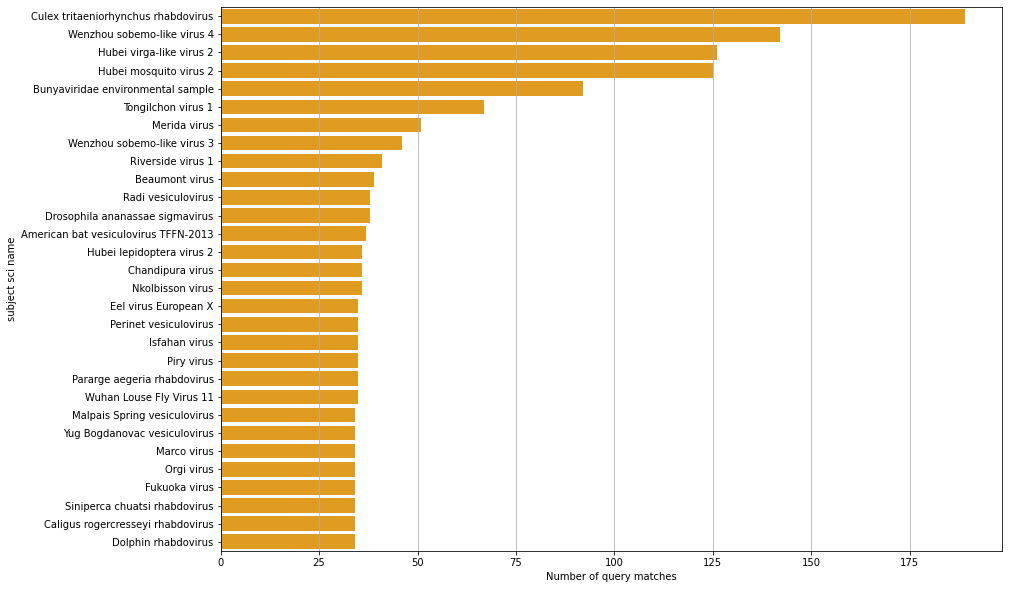

In [42]:
top_counts = counts[:30]
plt.figure(figsize=(14, 10))
plt.grid()
ax = sns.barplot(y=top_counts.index, x=top_counts, color='orange')
#ax.set_xticks(range(0, max(top_counts + 1), 10))
ax.set_xlabel('Number of query matches')
ax.set_ylabel(top_counts.name);

## Clean up cloud resources
### Delete Elastic-BLAST queue and compute environment in AWS
If you did not enable Elastic-BLAST auto-shutdown feature, the AWS Batch queue and compute environment have to be deleted manually.

In [ ]:
!elastic-blast delete --cfg {conf_file} --results s3://{RESULTS_BUCKET}

### Delete cloud bucket
If you do not need BLAST search results stored in the cloud, delete the cloud bucket so that you are not charged for it.

In [ ]:
!aws s3 rb s3://{RESULTS_BUCKET} --force

## Optional: Delete elastic-blast-janitor role
Deleting this role will disable Elastic-BLAST auto-shutdown feature. You are not paying for this role. It can be reused in future Elastic-BLAST searches.

In [ ]:
!sed -i~ -e '/export PATH/d' $(which aws-delete-elastic-blast-janitor-role.sh)
!aws-delete-elastic-blast-janitor-role.sh